In this demo exercise, we will be performing cluster analysis using K-Means clustering. 

We will be using the Numenta Anomaly Benchmark (NAB) dataset for this demo. The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. The NAB corpus consists of 58 real world and artifical timeseries data. We will specifically be using the "machine_temperature_system_failure.csv" dataset to detect any anomaly in the measurement of the temeprature of an internal component of a large, industrial mahcine.

All the datasets are available here: https://github.com/numenta/NAB/tree/master/data

 Our task is to perform anomaly detection on the dataset using K-Means clustering and predict if a new observation recorded by the sensor is normal or not. 

In [1]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
#load the dataset and print the first 5 rows
df = pd.read_csv("/content/drive/My Drive/machine_temperature_system_failure.csv")
df.head()

#the measurements are taken at an interval of 5 minutes

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [3]:
#get information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [4]:
#print the mean and standard deviation of temperature
print("mean temperature: ",df['value'].mean())
print("standard deviation: ",df['value'].std())

mean temperature:  85.92649821067992
standard deviation:  13.746912473090113


In [5]:
# true anomaly points in the dataset.
# these can be obtained from : https://github.com/numenta/NAB/blob/master/labels/combined_windows.json

#we will use these anomaly points to compare the clustering results with original results. Anomaly occured 4 times, each spanning
# a total of 2 days.

anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],  #start time, end time
        ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
]

# Data Preparation

In [6]:
#convert the timestamp column from type object to type datetime. Datetime sets the input argument into a format from which
#we can extract important information like day, date, year, time etc.

print("type before converting: ",df['timestamp'].dtype)
df['timestamp']=pd.to_datetime(df['timestamp'])   #use pd.to_datetime() to convert the column into type datetime
print("type before converting: ",df['timestamp'].dtype)

df['year'] = df['timestamp'].dt.year    #get year (2013,2014)
df['month'] = df['timestamp'].dt.month  #get month (1-12)
df['day'] = df['timestamp'].dt.day      #get day (1-31)
df['hour'] = df['timestamp'].dt.hour    # get hour (0-24)
df['minute'] = df['timestamp'].dt.minute  #get minute (0-60)

type before converting:  object
type before converting:  datetime64[ns]


In [7]:
df.head()

,timestamp,value,year,month,day,hour,minute
0,2013-12-02 21:15:00,73.967322,2013,12,2,21,15
1,2013-12-02 21:20:00,74.935882,2013,12,2,21,20
2,2013-12-02 21:25:00,76.124162,2013,12,2,21,25
3,2013-12-02 21:30:00,78.140707,2013,12,2,21,30
4,2013-12-02 21:35:00,79.329836,2013,12,2,21,35


In [8]:
#get information about new dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22695 non-null  datetime64[ns]
 1   value      22695 non-null  float64       
 2   year       22695 non-null  int64         
 3   month      22695 non-null  int64         
 4   day        22695 non-null  int64         
 5   hour       22695 non-null  int64         
 6   minute     22695 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 1.2 MB


In [9]:
# add an extra column in df specifying if measurement has anomaly (1) or not (0)
df['anomaly']=0  # if the column specified is not present in the dataframe, it will create a new column
df.head()

,timestamp,value,year,month,day,hour,minute,anomaly
0,2013-12-02 21:15:00,73.967322,2013,12,2,21,15,0
1,2013-12-02 21:20:00,74.935882,2013,12,2,21,20,0
2,2013-12-02 21:25:00,76.124162,2013,12,2,21,25,0
3,2013-12-02 21:30:00,78.140707,2013,12,2,21,30,0
4,2013-12-02 21:35:00,79.329836,2013,12,2,21,35,0


In [10]:
#set all anomaly points=1 
for start,end in anomaly_points:  #get the starting and ending time of anomaly
   df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1   #for all observations > start time and < end time, set df['anomaly']=1

df['anomaly'].value_counts()  #get the count of anomaly observations 

0    20427
1     2268
Name: anomaly, dtype: int64

In [11]:
# change fahrenheit to °C 
df['value'] = (df['value'] - 32) * 5/9

# Data visualization

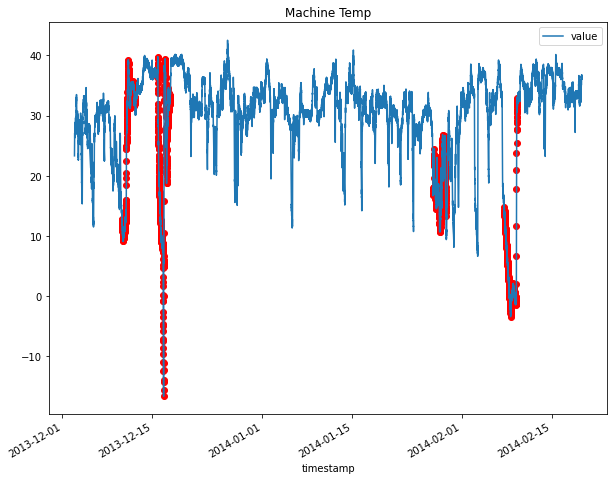

In [12]:
# plot the data- time series of temperature and scatterplot of anomaly observations
df.plot(x='timestamp', y='value',title='Machine Temp', figsize=(10,8))

anomaly_timestamp=df['timestamp'][df['anomaly']==1] #pick all timestamp values for which anomaly=1
anomaly_value=df['value'][df['anomaly']==1] #pick all temperatures for which anomaly=1
plt.scatter(anomaly_timestamp,anomaly_value,c='red') 

Text(0, 0.5, 'count')

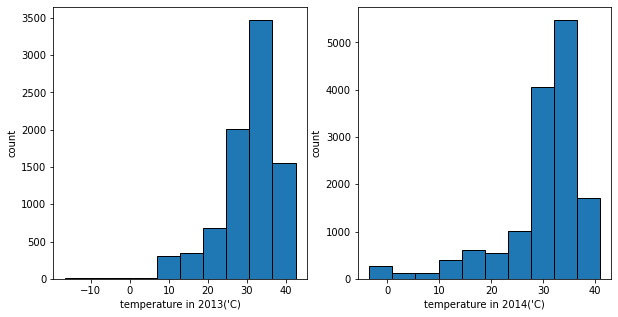

In [13]:
#visualize the distribution of temperature in 2013 and 2014 using histogram

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df["value"][df["year"]==2013],edgecolor="black") #all temperature values for which "year"=2013
plt.xlabel("temperature in 2013('C)")
plt.ylabel("count")

plt.subplot(1,2,2)
plt.hist(df["value"][df["year"]==2014],edgecolor="black") #all temperature values for which "year"=2014
plt.xlabel("temperature in 2014('C)")
plt.ylabel("count")

create new dataset

In [14]:
#create a new dataframe and drop the columns 'timestamp' and 'anomaly'
data = df.drop('timestamp',axis=1)  #drop timestamp
data.drop('anomaly',axis=1,inplace=True)  #drop anomaly 

data.head()

,value,year,month,day,hour,minute
0,23.315179,2013,12,2,21,15
1,23.853268,2013,12,2,21,20
2,24.513423,2013,12,2,21,25
3,25.633726,2013,12,2,21,30
4,26.294353,2013,12,2,21,35


# Dimensionality Reduction

In [15]:
# scale the inputs using StandardScaler function

from sklearn.preprocessing import StandardScaler
min_max_scaler = StandardScaler() #define an instance of StandardScaler
np_scaled = min_max_scaler.fit_transform(data)  #scale the dataframe
data = pd.DataFrame(np_scaled)  #convert the scaled input to a DataFrame variable

In [16]:
# we wish to visualize the clusters formed after k-means clustering, so we will reduce the dimensionality of the input
# using PCA.
from sklearn.decomposition import PCA #import the PCA function from sklearn

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)  #find the two principal components corresponding to the two highest eigen values and project the input data onto those components


# standardize these 2 new features
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Clustering using K-Means

Text(0, 0.5, 'sum of squares')

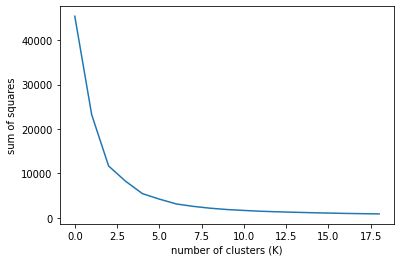

In [17]:
# calculate with different number of centroids to generate the sum of squares plot
from sklearn.cluster import KMeans

scores=[]   #define an empty list to store the sum of squares for each K value
for i in range(1,20): # select K value from 1 to 20
  k_means = KMeans(n_clusters=i,n_init=10,max_iter=300,random_state=48)  #define the KMeans instance
  '''
  n_clusters = number of clusters (K)
  n_init = number of times to run the KMeans algorithm. The best iteration is selected based on least sum of squares value
  max_iter = maximum number of iterations for the KMeans algorithm before stopping
  '''

  k_means.fit(data)   # form the clusters
  scores.append(k_means.inertia_) #k_means.inertia_ returns the sum of square of distance of data points from the cluster center

#plot the scores vs K
plt.plot(scores)
plt.xlabel('number of clusters (K)')
plt.ylabel('sum of squares')

In [18]:
#since the sum of squares is small for values between 12-20, we will try out the model with K=15

k_means = KMeans(n_clusters=15,n_init=10,max_iter=300,random_state=48,init='random')  #define the KMeans instance
k_means.fit(data)  

#create a new column in the dataframe 'data' with elements as the respective clusters
df['cluster']=k_means.predict(data)
df['cluster'].value_counts()  #get the number of elements in each cluster

2     3117
0     2989
7     2329
8     1896
11    1860
1     1833
12    1556
13    1442
14    1160
5     1137
3      907
10     799
6      710
4      563
9      397
Name: cluster, dtype: int64

In [19]:
# add the reduced dimensions to the original dataframe 'df'
df['principal_feature1'] = data[0]  #first principal component
df['principal_feature2'] = data[1]  #second principal component

Text(0, 0.5, 'PC2')

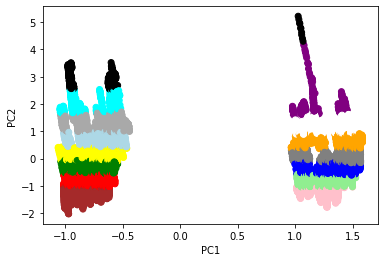

In [20]:
#plot the different clusters with the 2 main features
# to read and understand lambda function: https://www.w3schools.com/python/python_lambda.asp

colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan'
          , 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue',13:'lightgreen',14:'darkgrey'}
plt.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.xlabel("PC1")
plt.ylabel("PC2")

# Predicting Anomaly in the data

In [21]:
#define a function to get the distance of all the points from their cluster centers.
def getDistanceByPoint(data, model):
    distance = []   #define an empty list to store the distances
    for i in range(0,len(data)):  
        Xa = np.array(data.loc[i])  #get the ith row
        Xb = model.cluster_centers_[model.labels_[i]-1] #get the predicted cluster center of the ith row
        distance.append(np.linalg.norm(Xa-Xb))  #find the euclidean distance using numpy's norm function
    distance=pd.Series(distance)  #store the distances in the list
    return distance   #return the list 

In [22]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, k_means)
# we generally do not know the number of outlier points (anomalies) for a given dataset. But for the purpose of demonstration 
# we will assume that there are 2000 outlier points 
number_of_outliers = 2000

#get the 2000 largest distances from the list and find out the minimum of them. We will use this distance as the threshold.
threshold = distance.nlargest(number_of_outliers).min() 

#create a new column 'anomaly' in the dataframe 'df'. 
# (distance >=threshold ---> anomaly (1), distance < threshold ---> normal(0))
df['anomaly'] = (distance >= threshold).astype(int)

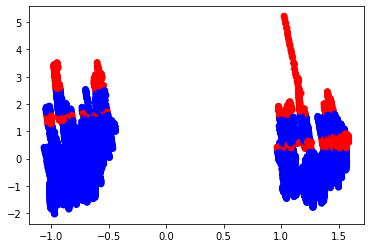

In [23]:
# visualize the anomaly points on the reduced dimensional data
colors = {0:'blue', 1:'red'}
plt.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly"].apply(lambda x: colors[x]))

Text(0.5, 1.0, 'machine temp')

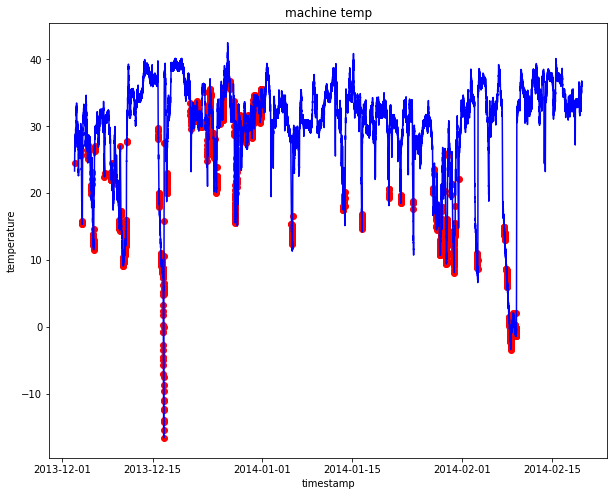

In [24]:
# visualisation of anomaly on the time series plot
a = df.loc[df['anomaly'] == 1, ['timestamp', 'value']] #create a new dataframe with timestamp and temperature value which are predicted as anomaly
plt.figure(figsize=(10,8))
plt.plot(df['timestamp'], df['value'], color='blue')  #plot the time series
plt.scatter(a['timestamp'],a['value'], color='red')   #plot the anomaly points
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("machine temp")

# Predicting Anomaly in New Observation

In [25]:
# decide if a new observation is an anomaly or not. We will randomly use one observation as the new observation.
new_data=data.iloc[[624]]

#define a function to get the distance of the test observation to its cluster center
def get_test_distance(data,model):
  n_cluster = k_means.predict(data) #predict the cluster for the given observation
  Xa = data  
  Xb = model.cluster_centers_[n_cluster] #get the cluster center for the predicted cluster
  distance = np.linalg.norm(Xa-Xb)  #find the euclidean distance using numpy's norm function
  return distance 


In [26]:
dist = get_test_distance(new_data,k_means)  #call the function
if dist > threshold:    #if the distance is greater than the threshold, the observation is anomaly
  print("anomaly observation")
else:
  print("normal observation")

normal observation
